### Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime

In [12]:
# Load the play store data
data =  pd.read_csv("Play_Store_Data.csv")
play_store_data = data.copy()

In [13]:
play_store_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [16]:
# Clean and convert columns
play_store_data['Installs'] = play_store_data['Installs'].replace('[+,]', '', regex=True).replace('Varies with device', np.nan)
play_store_data['Installs'] = pd.to_numeric(play_store_data['Installs'], errors='coerce')

play_store_data['Reviews'] = pd.to_numeric(play_store_data['Reviews'], errors='coerce')

play_store_data['Price'] = play_store_data['Price'].replace({'\$': '', 'Free': '0'}, regex=True)
play_store_data['Price'] = pd.to_numeric(play_store_data['Price'], errors='coerce')

play_store_data['Last Updated'] = pd.to_datetime(play_store_data['Last Updated'], errors='coerce')

# Drop rows with missing values in critical columns
play_store_data.dropna(subset=['Installs', 'Reviews', 'Price', 'Last Updated'], inplace=True)

# Check data types and structure
print(play_store_data.dtypes)

App                       object
Category                  object
Rating                   float64
Reviews                  float64
Size                      object
Installs                 float64
Type                      object
Price                    float64
Content Rating            object
Genres                    object
Last Updated      datetime64[ns]
Current Ver               object
Android Ver               object
dtype: object


### Scatter Plot: Revenue vs. Installs for Paid Apps

C:\Users\UPAM ACHARYA\AppData\Local\Temp\ipykernel_14948\4203844440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paid_apps['Revenue'] = paid_apps['Price'] * paid_apps['Installs']


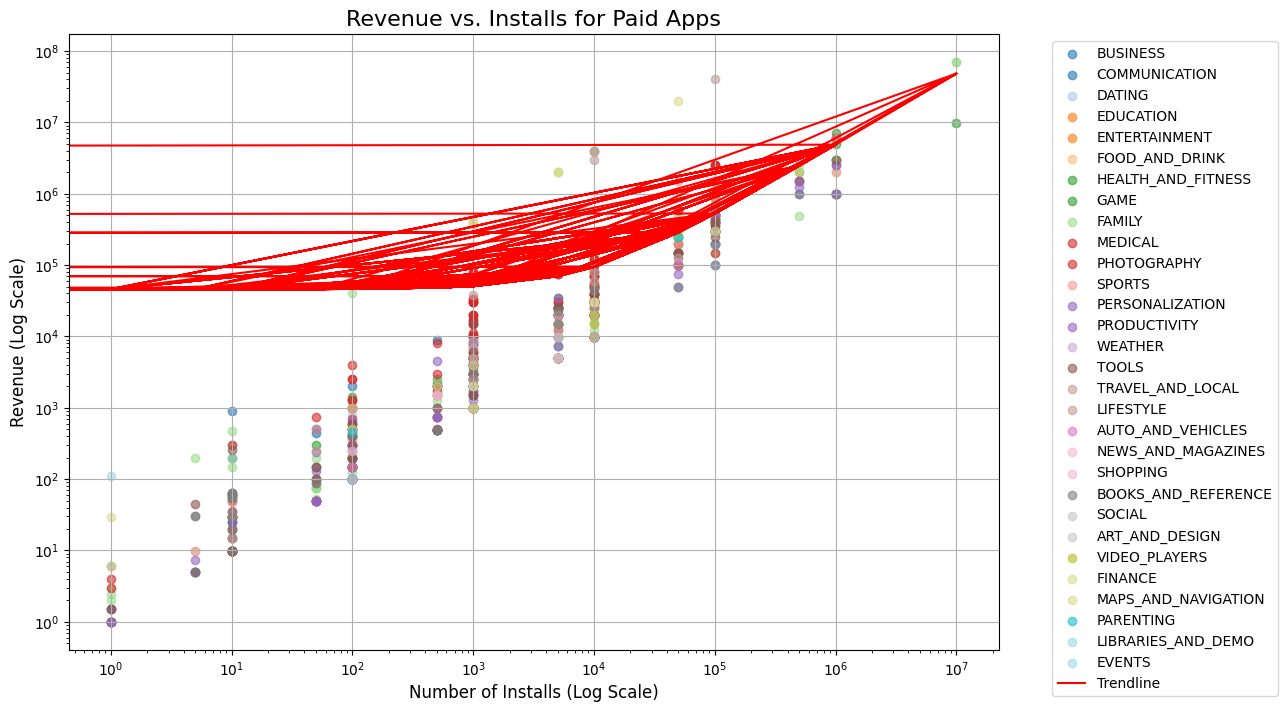

In [15]:
# Filter data for paid apps
paid_apps = play_store_data[play_store_data['Type'] == 'Paid']
paid_apps['Revenue'] = paid_apps['Price'] * paid_apps['Installs']

# Scatter plot with trendline
plt.figure(figsize=(12, 8))
categories = paid_apps['Category'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))

for category, color in zip(categories, colors):
    category_data = paid_apps[paid_apps['Category'] == category]
    plt.scatter(category_data['Installs'], category_data['Revenue'], label=category, alpha=0.6, color=color)

# Add trendline
z = np.polyfit(paid_apps['Installs'], paid_apps['Revenue'], 1)
p = np.poly1d(z)
plt.plot(paid_apps['Installs'], p(paid_apps['Installs']), color='red', label='Trendline')

# Customize plot
plt.xscale('log')
plt.yscale('log')
plt.title("Revenue vs. Installs for Paid Apps", fontsize=16)
plt.xlabel("Number of Installs (Log Scale)", fontsize=12)
plt.ylabel("Revenue (Log Scale)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

### Interactive Choropleth Map: Global Installs by Country

In [17]:
# Data filtering
top_categories = play_store_data['Category'].value_counts().head(5).index
filtered_data = play_store_data[
    (play_store_data['Category'].isin(top_categories)) &
    (~play_store_data['Category'].str.startswith(('A', 'C', 'G', 'S'))) &
    (play_store_data['Installs'] > 1_000_000)
]

# Adding a mock 'Country' column (real data should include country-level installs)
filtered_data['Country'] = np.random.choice(['USA', 'India', 'Germany', 'Brazil', 'Japan'], size=len(filtered_data))

# Time restriction logic
current_hour = datetime.now().hour
if not (12 <= current_hour <= 18):
    fig = px.choropleth(
        filtered_data,
        locations='Country',
        locationmode='country names',
        color='Installs',
        hover_name='Category',
        title="Global Installs by Country (Filtered)",
        color_continuous_scale=px.colors.sequential.Plasma,
    )
    fig.show()
else:
    print("This graph is not accessible between 12 PM and 6 PM.")

This graph is not accessible between 12 PM and 6 PM.


C:\Users\UPAM ACHARYA\AppData\Local\Temp\ipykernel_14948\1380740261.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Country'] = np.random.choice(['USA', 'India', 'Germany', 'Brazil', 'Japan'], size=len(filtered_data))


### Heatmap: Correlation Matrix

In [20]:
# Filter data
filtered_data = play_store_data[
    (play_store_data['Last Updated'] >= pd.Timestamp.now() - pd.Timedelta(days=365)) &
    (play_store_data['Installs'] >= 100_000) &
    (play_store_data['Reviews'] > 1_000) &
    (~play_store_data['Genres'].str.startswith(('A', 'F', 'E', 'G', 'I', 'K')))
]

# Time restriction logic
current_hour = datetime.now().hour
if 15 <= current_hour <= 18:
    corr_matrix = filtered_data[['Installs', 'Rating', 'Reviews']].corr()

    # Generate heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title("Correlation Matrix: Installs, Ratings, Reviews", fontsize=16)
    plt.show()
else:
    print("This graph is only accessible between 3 PM and 6 PM.")

This graph is only accessible between 3 PM and 6 PM.
